## A Notebook Using Herbie to Look at HRRR Cloud Forecasts

This notebook uses the new Herbie package to download HRRR fields, fix some metadata, fix some dimensions and merge fields. It also grabs one column of geopotential heights and uses this as a vertical axis to look at the structure of clouds over Chicago. The plan is to extract these columns and study the performance of HRRR and other models over Chicago using Argonne's scanning Doppler LIDAR, Ceilometer and other instruments. We also plan to do this study at [ARM's](http://www.arm.gov) Southern Great Plains site. 

**Note this shows cloud liquid and ice NOT precipitating water and ice... Future work.**

This notebook, given it takes 15 minutes to work on **the best** internet connections, inadervtantly makes the case for server side subsetting like the [HRRR ZARR archives](https://mesowest.utah.edu/html/hrrr/). This makes heavy use of [xarray](https://docs.xarray.dev/en/stable/) and we are always grateful to [Pangeo](https://pangeo.io/). 

Scott Collis, Argonne National Laboratory. [Twitter](https://twitter.com/Cyclogenesis_au) [GitHub](https://github.com/scollis)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import xarray as xr
import numpy as np

import cartopy.feature as cfeature
from cartopy import crs

from herbie import  FastHerbie, Herbie

# I like Py-ART's colorblind freindly colormaps
from pyart.graph import cm_colorblind 

import time
import warnings

#little helper func
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)


#I will put some PRs into Herbie, we get a bunch of warnings with the regex calls
warnings.filterwarnings(action='ignore')



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Set the start time of the model, number of forecast hours and how many cores to use and how many parallel downloads. 

In [2]:
tbegin = time.time() #Timing

mt = "2023-01-20 12:00"
nfcst = 47
nprocs = 5
source = 'aws'

Get the full four dimensional fields. **This is memory hungry, another case for the Pangeo lazy loading** on fast connections the downloads are faster than the loading. 

This downloads and loads grib files for cloud ice and cloud water mixing ratio into xarray. It also renames variables and fixes metadata for the ice fields. 

In [3]:
#Regex query string. Cloud water and cloud ice.
#See https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfnatf02.grib2.shtml
qstr = "(:CIMIXR:|:CLMR:)"
FH = FastHerbie([mt], model="hrrr",product="nat",source=source, fxx=range(0,nfcst))

#Download the subsets contianing the cloud fields. This can be 5 mins to 30 mins (ANL, Courtyard Marriott)
FH.download(qstr, max_threads=nprocs)
print('Downloaded')

#Load downloaded fields into a xarray dataset
ds_clouds = FH.xarray(qstr, remove_grib=True)

#Fix metadata
ds_clouds = ds_clouds.rename({'unknown' : 'cloudice', 'clwmr' : 'cloudwater'})
ds_clouds.cloudice.attrs['units'] = 'kg/kg'
ds_clouds.cloudice.attrs['long_name'] = 'Cloud ice mixing ratio'

tcloud = time.time() #timing

Downloaded


Now we download the 3D (time, y, x) surface fields. 

In [4]:
FH = FastHerbie([mt], model="hrrr", fxx=range(0,nfcst), source=source)

#Download temperature and Dewpoint at 2m
FH.download("(TMP|DPT):2 m", max_threads=nprocs)

#Load it into xarray
ds_t_and_dp = FH.xarray("(TMP|DPT):2 m", remove_grib=True)

ttemps = time.time()

Now the naming schema for one hour precipitation is complicated by the file contains total precipitation, 6 hour and 24 hour accumulations. So we brute force this query string.

In [5]:
qstr = '(' 
for i in range(nfcst):
    if i != nfcst -1:
        qstr = qstr +  f':APCP:surface:{i}-{i+1} ho*|'
    else:
        qstr = qstr +  f':APCP:surface:{i}-{i+1} ho*)'

H = Herbie(
    mt,  # model run date
    model="hrrr",  # model name
    product="sfc",  # model produce name (model dependent)
    fxx=24,  # forecast lead time
)

#Lets test!
H.read_idx(searchString=qstr)


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Jan-20 12:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
89,90,67313263,67856566,67313263-67856566,2023-01-20 12:00:00,2023-01-21 12:00:00,APCP,surface,23-24 hour acc fcst,:APCP:surface:23-24 hour acc fcst


Ok, now we have the search query we download the data. NOTE the zeroth hour has no accumulation so we "cheat" and expand the dimensions to match our other fields by duplicating the first entry.

In [6]:
#Download
FH = FastHerbie([mt], model="hrrr",source=source, fxx=range(1,nfcst))
FH.download(qstr, max_threads=nprocs) #This needs a good (and cheap) internet connection... ~1m on my connection

#Read to xarray
ds_rain = FH.xarray(qstr, remove_grib=True)

#Add a timestep at start
ds_rain = xr.concat([ds_rain.isel(step=0), ds_rain], dim='step')
ds_rain['step'] = ds_clouds['step']
ds_rain['valid_time'] = ds_clouds['valid_time']
ds_rain = ds_rain.rename({'tp': 'precip_accum_1hr'})

#set time zero to zero mm/hr
ds_rain.precip_accum_1hr[0, :, :] =  ds_rain.precip_accum_1hr[0, :, :]*0.0

tprecip = time.time() #timing

The data is in the natural [Sigma](https://en.wikipedia.org/wiki/Sigma_coordinate_system) coordinate system. In order to look at cloud heights we use Geopotentail hieghts. See this [Twitter Thread](https://twitter.com/Cyclogenesis_au/status/1614989311375540224). Note, as it is a smooth field (no zeros) geopotential hieghts do not compress well so file sizes are large. So we only grab one timestep and use that.

In [7]:
#Get vertical axis
FH = FastHerbie([mt], model="hrrr",product="nat",source=source, fxx=[0])
FH.download(':HGT:.*hybrid', max_threads=1) 
ds_heights = FH.xarray(':HGT:.*hybrid', remove_grib=True)

taxis = time.time() # timing

Now we do the merge. Merge the 4D and 3D fields. And take the 3D single timestep of hieghts. 

In [8]:
ds_precip = xr.merge([ds_rain, ds_clouds, ds_t_and_dp])
ds_precip['gph_zero_time'] = ds_heights.gh

#lets see what we have!
ds_precip

<xarray.Dataset>
Dimensions:              (step: 47, y: 1059, x: 1799, hybrid: 50)
Coordinates:
    time                 datetime64[ns] 2023-01-20T12:00:00
  * step                 (step) timedelta64[ns] 00:00:00 ... 1 days 22:00:00
    surface              float64 0.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           (step) datetime64[ns] 2023-01-20T12:00:00 ... 2023-0...
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    heightAboveGround    float64 2.0
Dimensions without coordinates: y, x
Data variables:
    precip_accum_1hr     (y, x, step) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    gribfile_projection  (step) object None None None None ... None None None
    cloudice             (step, hybrid, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    cloudwater           (step, hybrid, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    t2m                  (step, y, x) float32 291.6 291.6 291.6 ... 270.4 270.4
    d2m                  (step, y, x) float32 285.9 285.9 285.8 ... 266.2 266.2
    gph_zero_time        (hybrid, y, x) float32 10.61 10.61 ... 2.653e+04
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    searchString:            (:APCP:surface:0-1 ho*|:APCP:surface:1-2 ho*|:AP...

##  Ok!

Now we have the data in a nice format (I have no idea why the dims of the precip accums are swapped.. Any idea?) lets do some vis.. first some definitions and then lets take a 2D look at the precip and temperature.

First lets set up some stuff common to all plots.

In [9]:
#HRRR gives kg per m^2.. this is basically mm of rainfall. So convert to inches for our American audience 
inches_per_mm = 0.0393701

#The time step to show (hr 30 of 47). And some title text
timestep = 30
tstr = f"{ds_precip.model.upper()}: {ds_precip.description}\nValid: {ds_precip.valid_time[timestep].dt.strftime('%H:%M UTC %d %b %Y').item()}"

#Places we are intrerested in. Argonne National Lab, DOE ARM Facility's Southern Great Plains and St Louis
locations_of_interest = [(-87.9789, 41.7183),(-97.4882, 36.6077),( -90.1994, 38.6270)]
names_of_interest = ["Argonne", "ARM SGP", 'St Louis']

#Map parameters
my_transform = crs.PlateCarree()
my_extent = [-100, -85, 45, 33]
nlines = 5
lonlines = trunc(np.linspace(my_extent[0], my_extent[1], nlines), 1)
latlines = trunc(np.linspace(my_extent[2], my_extent[3], nlines), 1)

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

counties = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                            edgecolor='black', name='admin_2_counties_lakes', alpha=.2)


Map surface temperature and rainfall rate.. note this is rain and snow.. 

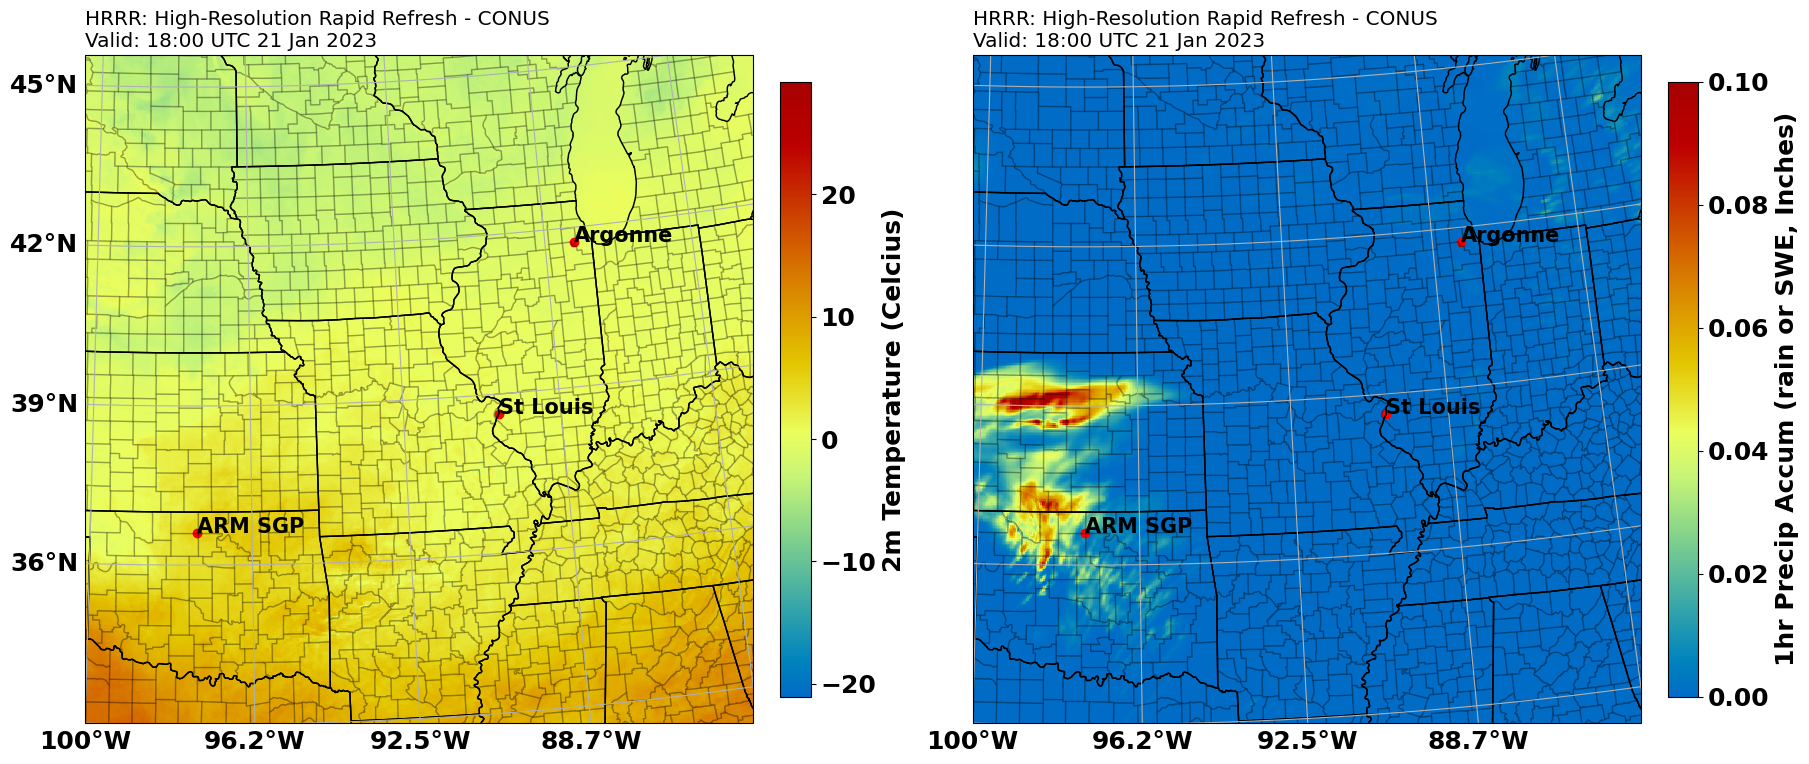

In [10]:
#Make a two panel figure
fig, (ax1, ax2) = plt.subplots( ncols=2, figsize=[18,8], constrained_layout=True,
                  subplot_kw={'projection' : ds_precip.herbie.crs})


#Plot 2m temperature
pc_temp = ax1.pcolormesh(ds_precip.longitude,  ds_precip.latitude, 
                         ds_precip.isel(step=timestep).t2m-273.15, cmap=cm_colorblind.HomeyerRainbow,
                        transform=my_transform)

c1 = plt.colorbar(pc_temp, fraction=0.046, pad=0.04)
c1.set_label(label='2m Temperature (Celcius)', size=18, weight='bold')
c1.ax.tick_params(labelsize=18) 

#Plot precip
pc_precip = ax2.pcolormesh(ds_precip.longitude,  ds_precip.latitude, 
                         ds_precip.isel(step=timestep).precip_accum_1hr*inches_per_mm, 
                           cmap=cm_colorblind.HomeyerRainbow,
                        transform=my_transform, vmin = 0, vmax=.1)

c2 = plt.colorbar(pc_precip, fraction=0.046, pad=0.04)
c2.set_label(label='1hr Precip Accum (rain or SWE, Inches)', size=18, weight='bold')
c2.ax.tick_params(labelsize=18) 


#Zoom
ax1.set_extent(my_extent, crs=my_transform)
ax2.set_extent(my_extent, crs=my_transform)

#Gridlines
gl1 = ax1.gridlines(xlocs=lonlines, ylocs=latlines, x_inline=False, rotate_labels=False)
gl2 = ax2.gridlines(xlocs=lonlines, ylocs=latlines, x_inline=False, rotate_labels=False)
gl1.xlabels_bottom = True
gl1.ylabels_left = True
gl2.xlabels_bottom = True
gl2.ylabels_left = False
gl1.xlabel_style = {'size': 18}
gl1.ylabel_style = {'size': 18}
gl2.xlabel_style = {'size': 18}
gl2.ylabel_style = {'size': 18}
ax1.set_title( tstr, loc="left")
ax2.set_title( tstr, loc="left")

#Map features
ax1.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
ax1.add_feature(coast, facecolor='none', edgecolor='black')
ax1.add_feature(counties, facecolor='none', edgecolor='black')
ax2.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
ax2.add_feature(coast, facecolor='none', edgecolor='black')
ax2.add_feature(counties, facecolor='none', edgecolor='black')

#Plot Locations
ax1.scatter([loc[0] for loc in locations_of_interest],
            [loc[1] for loc in locations_of_interest], transform=my_transform, marker='o', color='r')

for i in range(len(names_of_interest)):
    ax1.text(locations_of_interest[i][0],locations_of_interest[i][1], 
             names_of_interest[i], transform = my_transform, size=15 )
    
ax2.scatter([loc[0] for loc in locations_of_interest],
            [loc[1] for loc in locations_of_interest], transform=my_transform, marker='o', color='r')

for i in range(len(names_of_interest)):
    ax2.text(locations_of_interest[i][0],locations_of_interest[i][1], 
             names_of_interest[i], transform = my_transform, size=15 )

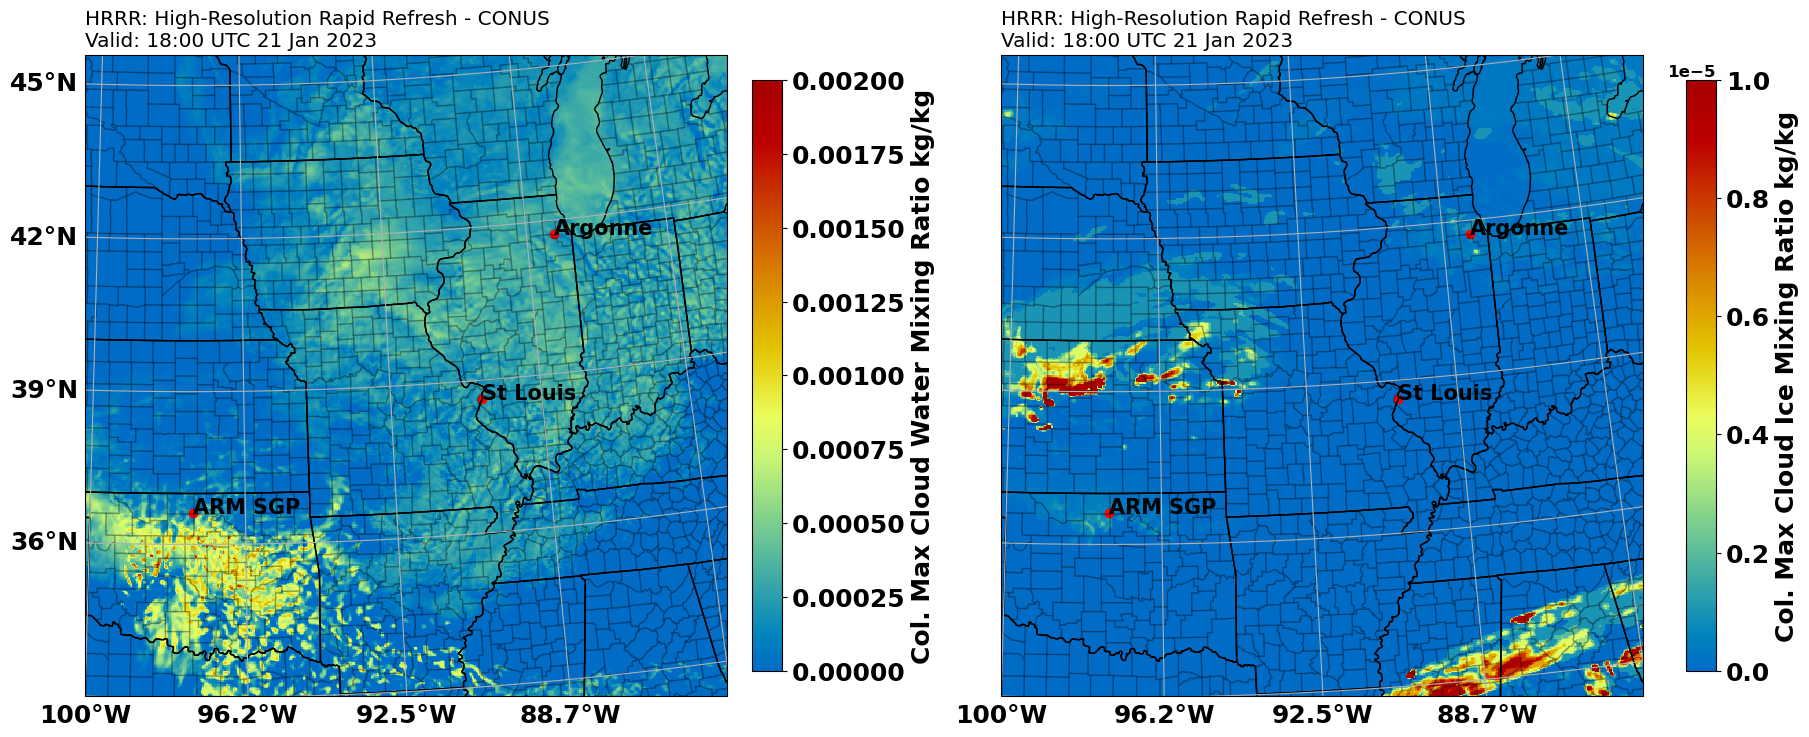

In [11]:
fig, (ax1, ax2) = plt.subplots( ncols=2, figsize=[18,8], constrained_layout=True,
                  subplot_kw={'projection' : ds_precip.herbie.crs})

pc_cw = ax1.pcolormesh(ds_precip.longitude,  ds_precip.latitude, 
                         ds_precip.cloudwater.isel(step=timestep).max(dim='hybrid'), cmap=cm_colorblind.HomeyerRainbow,
                        transform=my_transform, vmax=0.002)

c1 = plt.colorbar(pc_cw, fraction=0.046, pad=0.04)
c1.set_label(label='Col. Max Cloud Water Mixing Ratio kg/kg', size=18, weight='bold')
c1.ax.tick_params(labelsize=18) 

pc_ci = ax2.pcolormesh(ds_precip.longitude,  ds_precip.latitude, 
                         ds_precip.cloudice.isel(step=timestep).max(dim='hybrid'), cmap=cm_colorblind.HomeyerRainbow,
                        transform=my_transform, vmax=1e-5)

c2 = plt.colorbar(pc_ci, fraction=0.046, pad=0.04)
c2.set_label(label='Col. Max Cloud Ice Mixing Ratio kg/kg', size=18, weight='bold')
c2.ax.tick_params(labelsize=18) 



ax1.set_extent(my_extent, crs=my_transform)
ax2.set_extent(my_extent, crs=my_transform)

gl1 = ax1.gridlines(xlocs=lonlines, ylocs=latlines, x_inline=False, rotate_labels=False)
gl2 = ax2.gridlines(xlocs=lonlines, ylocs=latlines, x_inline=False, rotate_labels=False)

gl1.xlabels_bottom = True
gl1.ylabels_left = True
gl2.xlabels_bottom = True
gl2.ylabels_left = False

gl1.xlabel_style = {'size': 18}
gl1.ylabel_style = {'size': 18}

gl2.xlabel_style = {'size': 18}
gl2.ylabel_style = {'size': 18}


ax1.set_title( tstr, loc="left")
ax2.set_title( tstr, loc="left")

ax1.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
ax1.add_feature(coast, facecolor='none', edgecolor='black')
ax1.add_feature(counties, facecolor='none', edgecolor='black')

ax2.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
ax2.add_feature(coast, facecolor='none', edgecolor='black')
ax2.add_feature(counties, facecolor='none', edgecolor='black')

ax1.scatter([loc[0] for loc in locations_of_interest],
            [loc[1] for loc in locations_of_interest], transform=my_transform, marker='o', color='r')

for i in range(len(names_of_interest)):
    ax1.text(locations_of_interest[i][0],locations_of_interest[i][1], 
             names_of_interest[i], transform = my_transform, size=15 )
    
ax2.scatter([loc[0] for loc in locations_of_interest],
            [loc[1] for loc in locations_of_interest], transform=my_transform, marker='o', color='r')

for i in range(len(names_of_interest)):
    ax2.text(locations_of_interest[i][0],locations_of_interest[i][1], 
             names_of_interest[i], transform = my_transform, size=15 )

## Now, lets look at some locations.

We noted Argonne, the SGP and St Louis before. Herbie has a neat accessor for reducing the data to points and columns. 

In [12]:
dsi = ds_precip.herbie.nearest_points(locations_of_interest, 
                               names=names_of_interest)
dsi

<xarray.Dataset>
Dimensions:              (step: 47, point: 3, hybrid: 50)
Coordinates:
    time                 datetime64[ns] 2023-01-20T12:00:00
  * step                 (step) timedelta64[ns] 00:00:00 ... 1 days 22:00:00
    surface              float64 0.0
    latitude             (point) float64 41.71 36.61 38.62
    longitude            (point) float64 272.0 262.5 269.8
    valid_time           (step) datetime64[ns] 2023-01-20T12:00:00 ... 2023-0...
    heightAboveGround    float64 2.0
    metpy_crs            object Projection: lambert_conformal_conic
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    y                    (point) float64 3.987e+05 -2.103e+05 3.869e+04
    x                    (point) float64 7.915e+05 2.48e+03 6.325e+05
  * point                (point) <U8 'Argonne' 'ARM SGP' 'St Louis'
Data variables:
    precip_accum_1hr     (point, step) float32 0.011 0.011 0.0 ... 0.298 0.255
    gribfile_projection  (point, step) object None None None ... None None None
    cloudice             (point, step, hybrid) float32 0.0 0.0 0.0 ... 0.0 0.0
    cloudwater           (point, step, hybrid) float32 0.0 0.0 0.0 ... 0.0 0.0
    t2m                  (point, step) float32 273.5 273.1 273.1 ... 273.2 273.2
    d2m                  (point, step) float32 272.0 271.5 271.1 ... 272.8 272.8
    gph_zero_time        (point, hybrid) float32 222.2 249.0 ... 2.722e+04
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    searchString:            (:APCP:surface:0-1 ho*|:APCP:surface:1-2 ho*|:AP...

Now lets visiualize it! Lets start with the Chicago column! Here is where we use the geopotential heights as the vertical axis. 

Text(0.5, 1.0, 'HRRR rain rate forecasts')

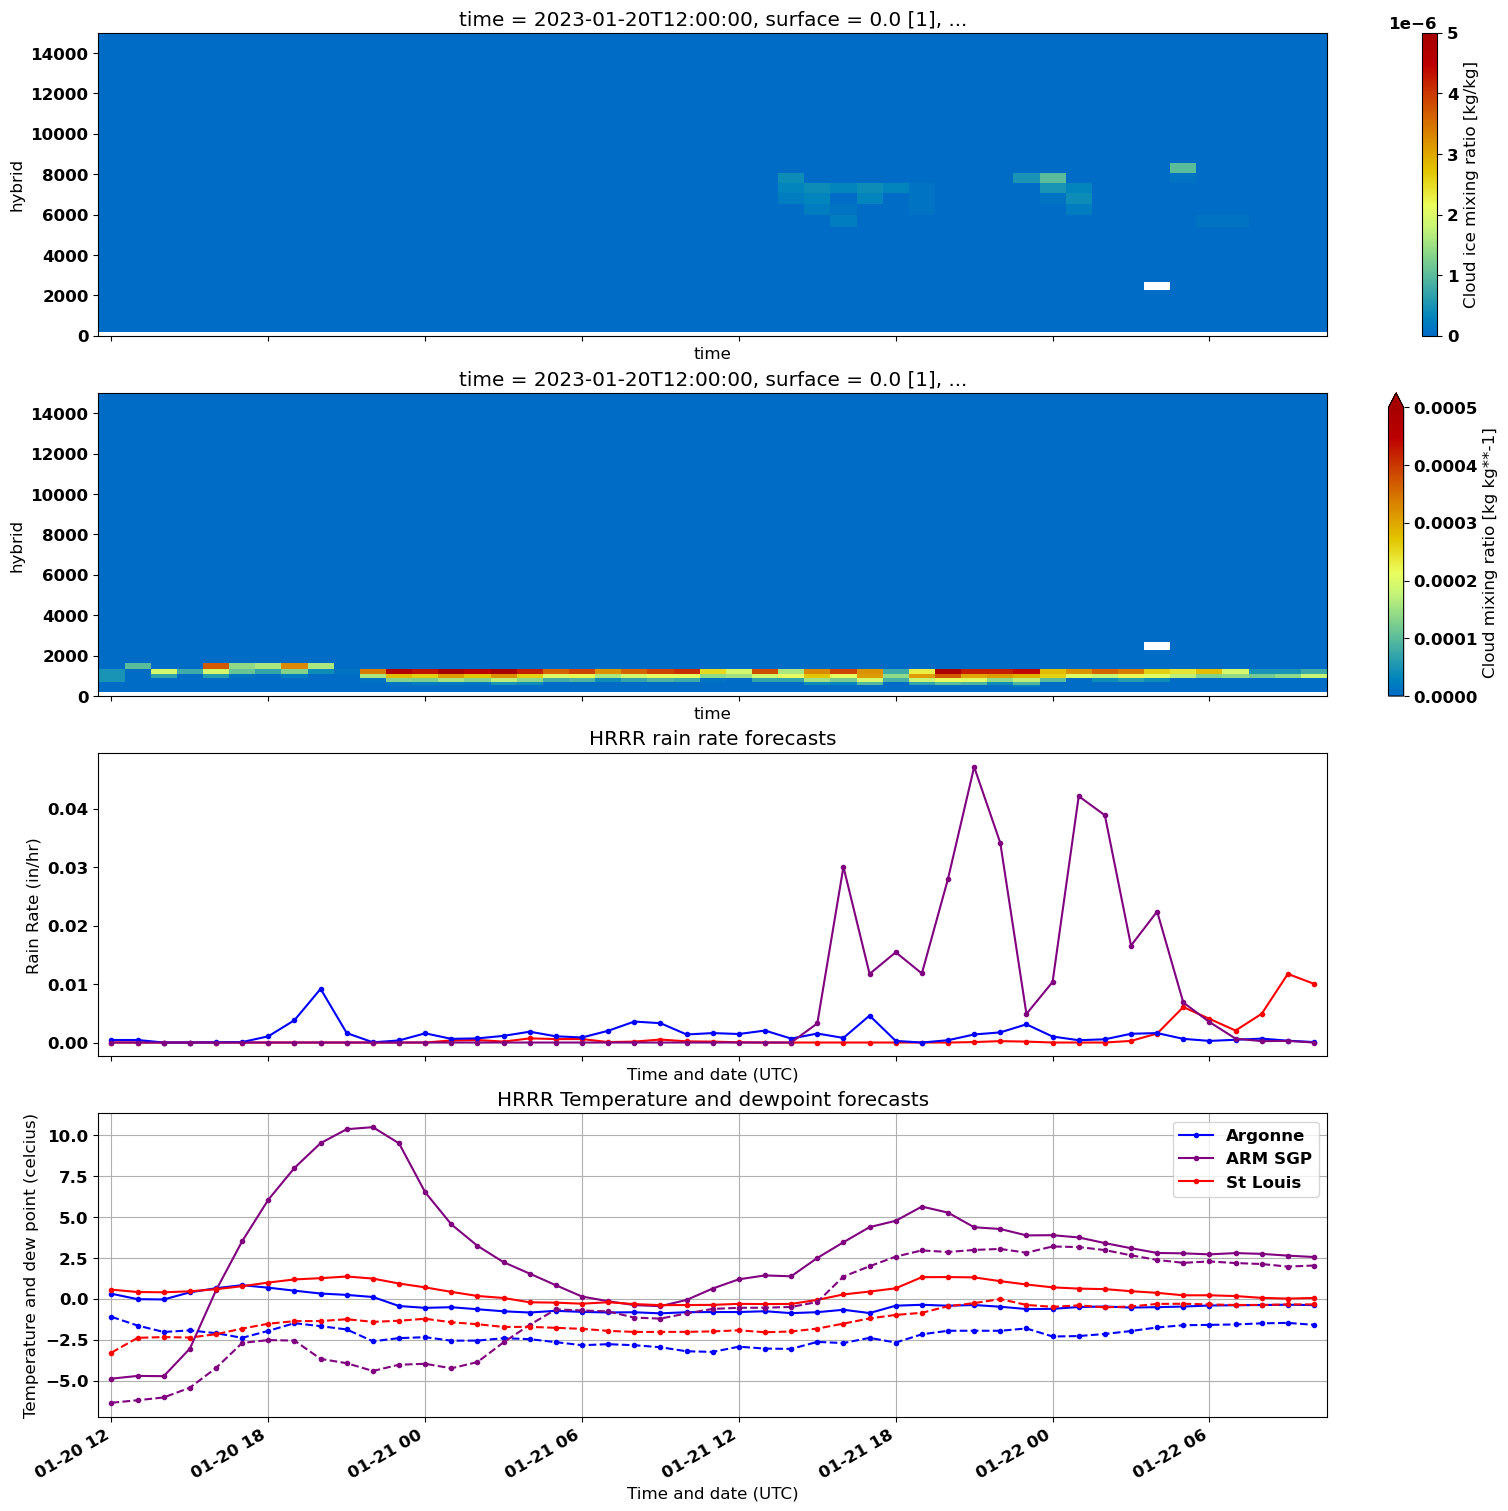

In [13]:
#Make a figure with four rows. 
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(nrows = 4, sharex=True, constrained_layout=True, figsize=[15,15])


#Use GPH at t=0 as the vertical axis and plot cloud ice and cloud water for one site
dsi.isel(point=0).set_index(hybrid="gph_zero_time").cloudice.plot(x="valid_time", vmin=0, vmax=5e-6, 
                                                        cmap = cm_colorblind.HomeyerRainbow, ax=ax1)


dsi.isel(point=0).set_index(hybrid="gph_zero_time").cloudwater.plot(x="valid_time", vmin=0, vmax=0.0005, 
                                                        cmap = cm_colorblind.HomeyerRainbow, ax=ax2)



#Plot precip 1hr accums for all sites
(dsi.precip_accum_1hr*inches_per_mm).isel(point=2).plot(color='red', 
                                                      x="valid_time", marker=".", 
                                                      label=dsi.point[2].values,
                                                     ax=ax3)


(dsi.precip_accum_1hr*inches_per_mm).isel(point=0).plot(color='blue', 
                                                      x="valid_time", marker=".", 
                                                      label=dsi.point[0].values,
                                                     ax = ax3)

(dsi.precip_accum_1hr*inches_per_mm).isel(point=1).plot(color='purple', 
                                                      x="valid_time", marker=".",
                                                      label=dsi.point[1].values,
                                                     ax=ax3)


#plot temperature and dewpoints for all sites. 
(dsi.t2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", label=dsi.point[0].values, ax=ax4)
(dsi.t2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", label=dsi.point[1].values, ax=ax4)
(dsi.t2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", label=dsi.point[2].values, ax=ax4)

(dsi.d2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", linestyle='dashed', ax=ax4)
(dsi.d2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", linestyle='dashed', ax=ax4)
(dsi.d2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", linestyle='dashed', ax=ax4)


#Embelish
ax4.set_ylabel('Temperature and dew point (celcius)')
ax4.set_xlabel('Time and date (UTC)')
ax4.set_title('HRRR Temperature and dewpoint forecasts')


plt.legend()

ax1.set_ylim([0, 15000])
ax2.set_ylim([0, 15000])
#ax3.set_ylim([0,.5])
plt.grid()
ax3.set_ylabel('Rain Rate (in/hr)')
ax3.set_xlabel('Time and date (UTC)')
ax3.set_title('HRRR rain rate forecasts')

# Now we do SGP!

Text(0.5, 1.0, 'HRRR rain rate forecasts')

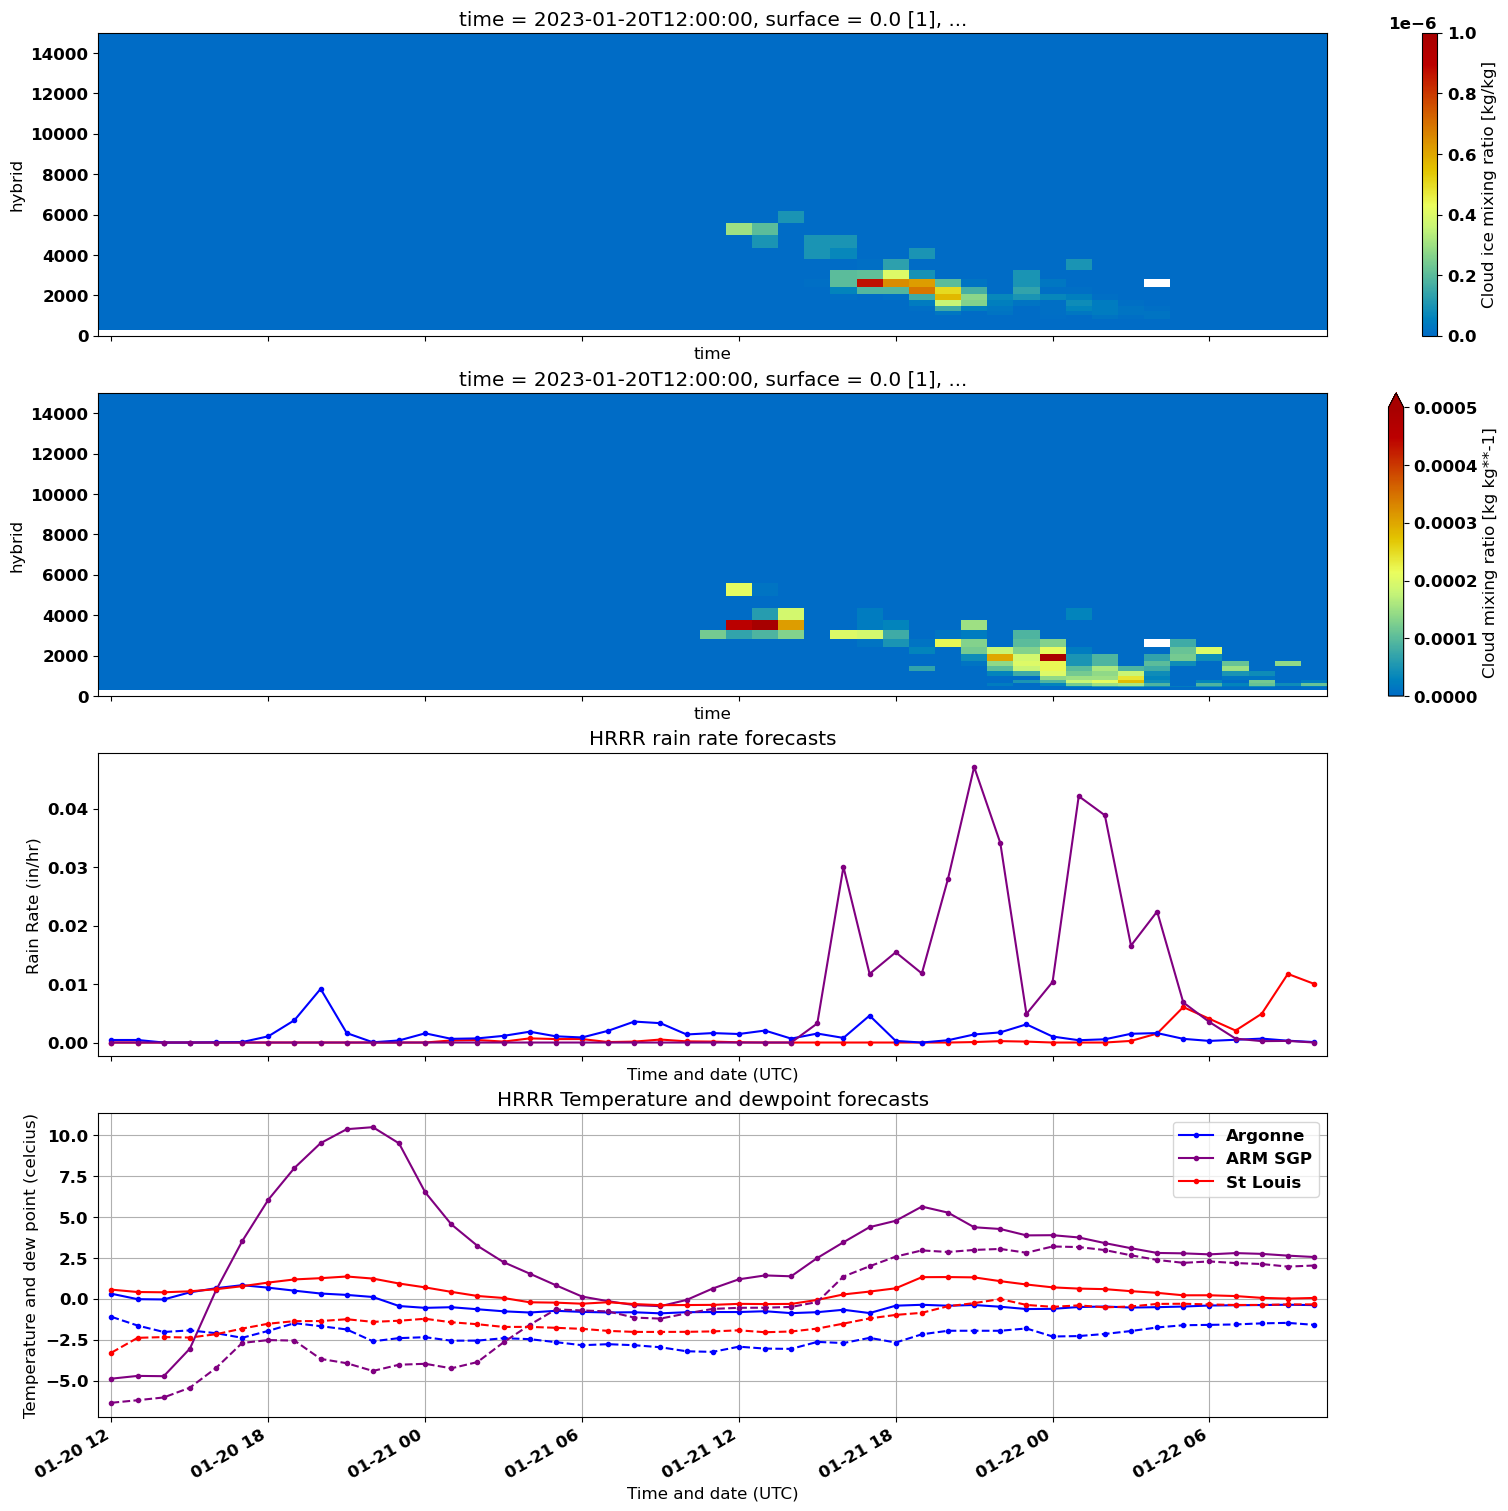

In [14]:
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(nrows = 4, sharex=True, constrained_layout=True, figsize=[15,15])

dsi.isel(point=1).set_index(hybrid="gph_zero_time").cloudice.plot(x="valid_time", vmin=0, vmax=1e-6, 
                                                        cmap = cm_colorblind.HomeyerRainbow, ax=ax1)


dsi.isel(point=1).set_index(hybrid="gph_zero_time").cloudwater.plot(x="valid_time", vmin=0, vmax=0.0005, 
                                                        cmap = cm_colorblind.HomeyerRainbow, ax=ax2)


(dsi.precip_accum_1hr*inches_per_mm).isel(point=2).plot(color='red', 
                                                      x="valid_time", marker=".", 
                                                      label=dsi.point[2].values,
                                                     ax=ax3)


(dsi.precip_accum_1hr*inches_per_mm).isel(point=0).plot(color='blue', 
                                                      x="valid_time", marker=".", 
                                                      label=dsi.point[0].values,
                                                     ax = ax3)

(dsi.precip_accum_1hr*inches_per_mm).isel(point=1).plot(color='purple', 
                                                      x="valid_time", marker=".",
                                                      label=dsi.point[1].values,
                                                     ax=ax3)




(dsi.t2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", label=dsi.point[0].values, ax=ax4)
(dsi.t2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", label=dsi.point[1].values, ax=ax4)
(dsi.t2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", label=dsi.point[2].values, ax=ax4)

(dsi.d2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", linestyle='dashed', ax=ax4)
(dsi.d2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", linestyle='dashed', ax=ax4)
(dsi.d2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", linestyle='dashed', ax=ax4)

#plt.grid()
ax4.set_ylabel('Temperature and dew point (celcius)')
ax4.set_xlabel('Time and date (UTC)')
ax4.set_title('HRRR Temperature and dewpoint forecasts')


plt.legend()

ax1.set_ylim([0, 15000])
ax2.set_ylim([0, 15000])
#ax3.set_ylim([0,.5])
plt.grid()
ax3.set_ylabel('Rain Rate (in/hr)')
ax3.set_xlabel('Time and date (UTC)')
ax3.set_title('HRRR rain rate forecasts')

## Woo hoo!

Note the marked difference. You can see a diurnal cycle in SGP due to nice clear skies. Also some proper mixed phase clouds with some light rain. Persisten cloud deck in Chicago with some light snowfall. This gives a general guide on how to make nice time height series using Herbie, xarray and matplotlib. 

Now, the challenge. Do this with streaming data and/or lazy loading. Fi